In [1]:
import pandas as pd
import utilsNb as utils
import torch
import transformers
import numpy as np

from sklearn.metrics import classification_report
from transformers import pipeline
from tqdm import tqdm


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
transformers.logging.set_verbosity_error()

# reload modules
%load_ext autoreload
%autoreload 2




In [2]:
# df = pd.read_csv("../data/final_test_esg2.csv")
df = pd.read_csv("../data/final_test_esg2.csv", encoding="utf-8")
X_test = df["text"].to_numpy()
y_test = df["esg_category"].to_numpy()

In [3]:
from sklearn.metrics import f1_score, recall_score, precision_score
from sklearn.metrics import confusion_matrix


def get_weights(X, y, models_dict, evaluation_metric="f1"):
    metrics = {
        "f1": f1_score,
        "recall": recall_score,
        "precision": precision_score
    }
    
    if evaluation_metric not in metrics:
        raise ValueError(f"Invalid evaluation metric '{evaluation_metric}'. Choose from 'f1', 'recall', or 'precision'.")

    metric_function = metrics[evaluation_metric]
    metric_values = []
        
    # step by step print to view each values 
    for model, tokenizer, tokenizer_max_len in models_dict.values():
        vectorized_predict = np.vectorize(utils.predict_single_input)
        with tqdm(total=len(X)) as pbar:
            y_pred, _, _ = vectorized_predict(model, tokenizer, X, tokenizer_max_len, pbar=pbar)
            metric_value = metric_function(y, y_pred, average=None)
            metric_values.append(metric_value)
        print(f"Metric values:\n {metric_values} \n")
    
    metric_values = np.array(metric_values)
    normalized_weights = metric_values / np.sum(metric_values, axis=0, keepdims=True)
    print(f"normalized weights:\n\n {normalized_weights}\n")

    return normalized_weights


    
    



# Finetuned models

The following models have been finetuned on the dataset "*esg_fr_classification.csv*". Analysis of the dataset can be found in the separate notebook *dataset_analysis.ipynb* 

In [4]:
model_cbl, tokenizer_large = utils.load_sd_model("cbl-512",model_sd_path='../models/model-cbl/run1/models/state_dict/cb_large_model1_sd.pt') 
model_cbl_1024, _ = utils.load_sd_model("cbl-1024",model_sd_path='../models/model-cbl-long/run1/models/state_dict/cbl_model_long_sd.pt', )
# model_cb, tokenizer_base = utils.load_sd_model("cb-512",model_sd_path='../models/model-cb/run1/models/state_dict/model_cb_sd.pt')
model_cb, tokenizer_base = utils.load_sd_model("cb-512",model_sd_path='../models/model-cb/run4/models/state_dict/cb_sd.pt')
model_cb_1024, _ = utils.load_sd_model("cb-1024",model_sd_path='../models/model-cb-long/run1/models/state_dict/camembert_long_state_dict.pt')

ValueError: Non-consecutive added token '<mask>' found. Should have index 32005 but has index 32004 in saved vocabulary.

In [8]:
models_dict = {
    "cb-512": [model_cb, tokenizer_base, 512],
    "cb-1024": [model_cb_1024, tokenizer_base, 1024],
    "cbl-512": [model_cbl, tokenizer_large, 512],
    "cbl-1024": [model_cbl_1024, tokenizer_large, 1024],
}
# models_dict = {
#     "cb-512": [1, 2, 512],
#     "cbl-512": [3, 4, 512],
#     "cbl-1024": [5, 6, 1024],
# }

weights = get_weights(X_test, y_test, models_dict, evaluation_metric="f1")

72it [00:07,  9.60it/s]                        
72it [00:07, 10.18it/s]                        
72it [00:27,  2.65it/s]                        
72it [00:30,  2.33it/s]                        


## CHECK PRECISION TOO

In [17]:
weights

array([[0.2636232 , 0.24361493, 0.28944688, 0.24629182],
       [0.23410941, 0.25933202, 0.23502097, 0.23456364],
       [0.25657445, 0.25933202, 0.248515  , 0.31390135],
       [0.24569294, 0.23772102, 0.22701716, 0.20524319]])

## Model Camembert-base-512

100%|██████████| 71/71 [00:06<00:00, 10.66it/s]


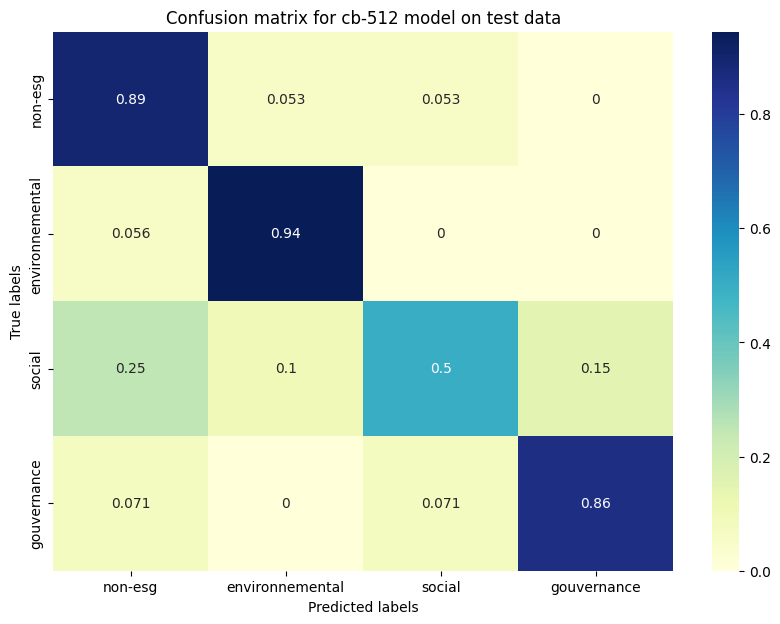

                 precision    recall  f1-score   support

environnemental       0.85      0.94      0.89        18
    gouvernance       0.80      0.86      0.83        14
        non-esg       0.71      0.89      0.79        19
         social       0.83      0.50      0.62        20

       accuracy                           0.79        71
      macro avg       0.80      0.80      0.78        71
   weighted avg       0.80      0.79      0.78        71



In [10]:
df_res = utils.predict_df(df, model_cb, tokenizer_base, tokenizer_max_len=512, return_prediction_only=True, column_name="cb_pred")

utils.print_confusion_matrix(df_res["esg_category"], df_res['cb_pred'], title = "Confusion matrix for cb-512 model on test data")
report = classification_report(df_res['esg_category'], df_res['cb_pred'], zero_division=0)
print(report)

100%|██████████| 71/71 [00:05<00:00, 12.53it/s]


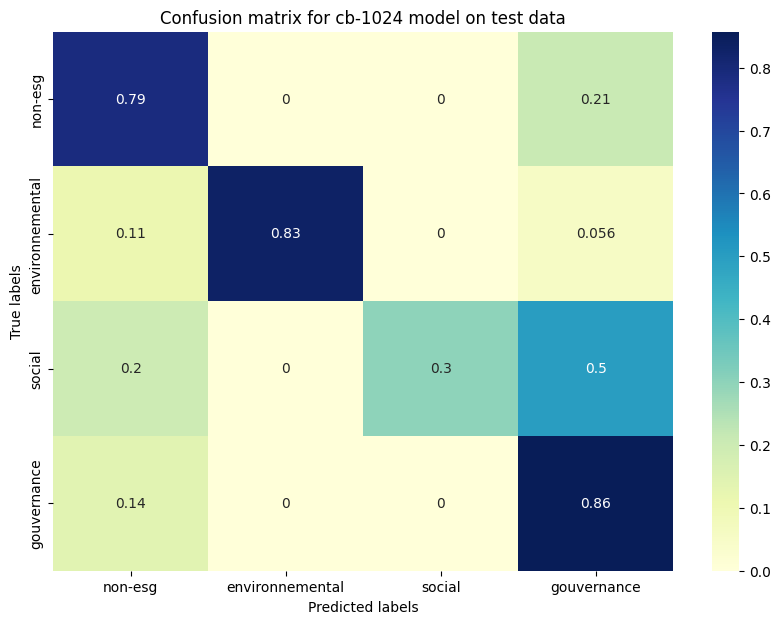

                 precision    recall  f1-score   support

environnemental       1.00      0.83      0.91        18
    gouvernance       0.44      0.86      0.59        14
        non-esg       0.65      0.79      0.71        19
         social       1.00      0.30      0.46        20

       accuracy                           0.68        71
      macro avg       0.77      0.69      0.67        71
   weighted avg       0.80      0.68      0.67        71



In [11]:
df_res = utils.predict_df(df_res, model_cb_1024, tokenizer_base, tokenizer_max_len=1024, return_prediction_only=True, column_name="cb_1024_pred")

utils.print_confusion_matrix(df_res["esg_category"], df_res['cb_1024_pred'], title = "Confusion matrix for cb-1024 model on test data")
report = classification_report(df_res['esg_category'], df_res['cb_1024_pred'], zero_division=0)
print(report)

## Model Camembert-large-512 

In [12]:
df_res = utils.predict_df(df_res, model_cbl, tokenizer_large, tokenizer_max_len=512, return_prediction_only=True, column_name="cbl_pred")

100%|██████████| 71/71 [00:17<00:00,  4.02it/s]


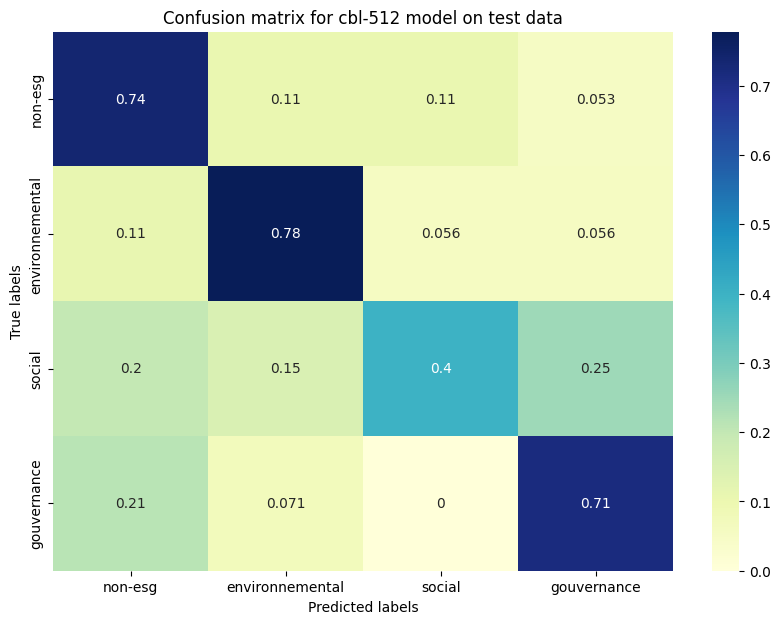

                 precision    recall  f1-score   support

environnemental       0.70      0.78      0.74        18
    gouvernance       0.59      0.71      0.65        14
        non-esg       0.61      0.74      0.67        19
         social       0.73      0.40      0.52        20

       accuracy                           0.65        71
      macro avg       0.66      0.66      0.64        71
   weighted avg       0.66      0.65      0.64        71



In [13]:
utils.print_confusion_matrix(df_res["esg_category"], df_res['cbl_pred'], title = "Confusion matrix for cbl-512 model on test data")
report = classification_report(df_res['esg_category'], df_res['cbl_pred'], zero_division=0)
print(report)

## Model Camembert-large-1024 

In [14]:
df_res = utils.predict_df(df_res, model_cbl_1024, tokenizer_large, tokenizer_max_len=1024, return_prediction_only=True, column_name="cbl_1024_pred")

100%|██████████| 71/71 [00:18<00:00,  3.90it/s]


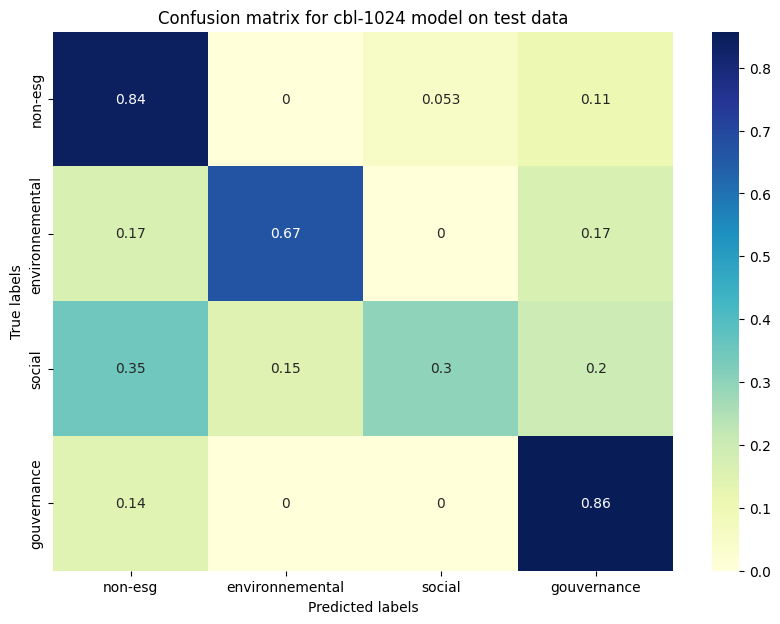

                 precision    recall  f1-score   support

environnemental       0.80      0.67      0.73        18
    gouvernance       0.57      0.86      0.69        14
        non-esg       0.57      0.84      0.68        19
         social       0.86      0.30      0.44        20

       accuracy                           0.65        71
      macro avg       0.70      0.67      0.63        71
   weighted avg       0.71      0.65      0.63        71



In [15]:
utils.print_confusion_matrix(df["esg_category"], df_res['cbl_1024_pred'], title = "Confusion matrix for cbl-1024 model on test data")
report = classification_report(df['esg_category'], df_res['cbl_1024_pred'], zero_division=0)
print(report)

# Zero-shot models

Zero-shot classification is performed using the following models:

<!-- add urls -->



In [16]:
ESG_DICT = {
    "environnemental": ["changement climatique", "capital naturel", "pollution et déchets", "Opportunités environnementales"],
    "social": ["capital humain", "responsabilité du produit", "opposition des parties prenantes", "opportunités sociales", "services publiques"],
    "gouvernance": ["gouvernance d'entreprises", "comportement d'entreprises"],
    "non-esg": ["autre","divertissement"]
}
classifier = pipeline("zero-shot-classification", model="MoritzLaurer/mDeBERTa-v3-base-mnli-xnli")


def predict_sample(sample, candidate_labels, top_k = 3, return_all = False):
    output = classifier(sample, candidate_labels, multi_label=False)
    output_df = pd.DataFrame(output)[["labels", "scores"]][:top_k]
    # find the key from the esg_dict
    output_df["key_label"] = output_df["labels"].apply(lambda x: [key for key, value in ESG_DICT.items() if x in value][0])

    count_dict = {}
    for label in output_df["key_label"]:
        count_dict[label] = count_dict.get(label, 0) + 1

    best_choice = max(count_dict, key=count_dict.get)

    if return_all: return output_df, best_choice

    return best_choice

CANDIDATE_LABELS = list(ESG_DICT.values())
CANDIDATE_LABELS = [item for sublist in CANDIDATE_LABELS for item in sublist]

## MoritzLaurer/mDeBERTa-v3-base-mnli-xnli

In [17]:
df_res['0-shot'] = None
for i,row in tqdm(df_res.iterrows(), total = len(df_res)):
    df_res.at[i,'0-shot'] = predict_sample(row['text'], CANDIDATE_LABELS)
    
debert_base_preds = df_res['0-shot']

100%|██████████| 164/164 [15:58<00:00,  5.85s/it]


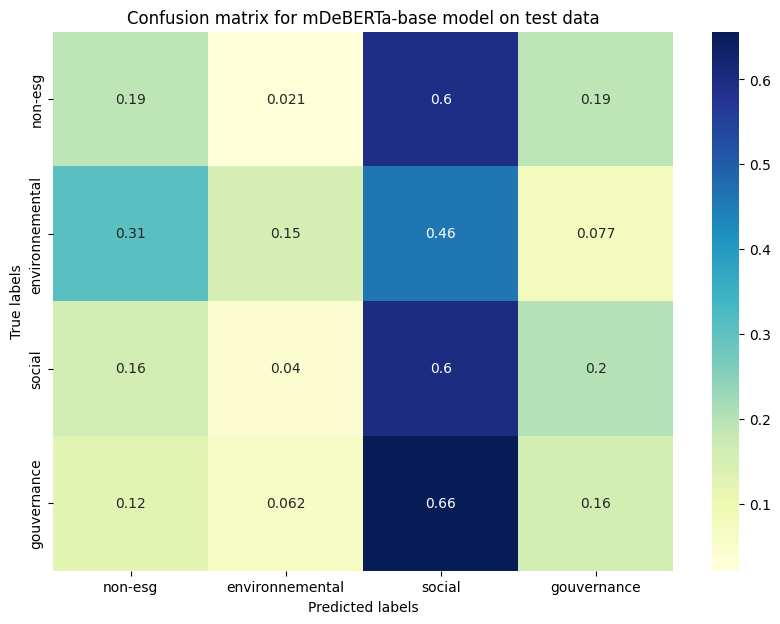

                 precision    recall  f1-score   support

environnemental       0.29      0.15      0.20        13
    gouvernance       0.17      0.16      0.16        32
        non-esg       0.60      0.19      0.29        94
         social       0.15      0.60      0.24        25

       accuracy                           0.24       164
      macro avg       0.30      0.28      0.22       164
   weighted avg       0.42      0.24      0.25       164



In [19]:
utils.print_confusion_matrix(df["esg_category"], debert_base_preds, title = "Confusion matrix for mDeBERTa-base model on test data")
print(classification_report(df['esg_category'], debert_base_preds, zero_division=0))

## MoritzLaurer/deberta-v3-large-zeroshot-v1.1-all-33

In [20]:
from transformers import pipeline
from easynmt import EasyNMT
import warnings
warnings.filterwarnings('ignore')

pipe = pipeline("zero-shot-classification", model="MoritzLaurer/deberta-v3-large-zeroshot-v1.1-all-33")
model = EasyNMT('opus-mt',cache_folder="./NMT_model_cache")

In [ ]:
df_res['0-shot-EN'] = None
for i,row in tqdm(df_res.iterrows(), total = len(df_res)):
    fr_text = row['text']
    en_text = model.translate(fr_text, source_lang='fr', target_lang='en')
    df_res.at[i,'0-shot-EN'] = predict_sample(en_text, CANDIDATE_LABELS)

debert_large_preds = df_res['0-shot-EN']

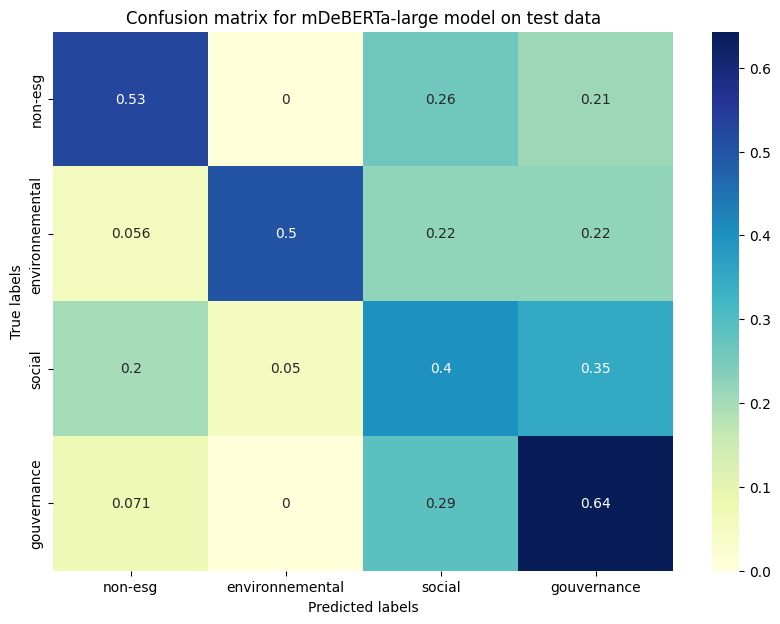

                 precision    recall  f1-score   support

environnemental       0.90      0.50      0.64        18
    gouvernance       0.38      0.64      0.47        14
        non-esg       0.62      0.53      0.57        19
         social       0.38      0.40      0.39        20

       accuracy                           0.51        71
      macro avg       0.57      0.52      0.52        71
   weighted avg       0.58      0.51      0.52        71



In [ ]:
utils.print_confusion_matrix(df["esg_category"], debert_large_preds, title = "Confusion matrix for mDeBERTa-large model on test data")
print(classification_report(df['esg_category'], debert_large_preds, zero_division=0))

# Weighted Average prediction by  *ensemble learning*

In [29]:
df_res

,text,esg_category,cb_pred,cb_1024_pred,cbl_pred,cbl_1024_pred
0,La vague de chaleur a poussé le Département de...,environnemental,environnemental,non-esg,environnemental,environnemental
1,La météo moins chaude des derniers jours a aid...,environnemental,environnemental,environnemental,environnemental,gouvernance
2,Les précipitations importantes liées à la temp...,environnemental,environnemental,environnemental,environnemental,environnemental
3,La météo dans tous ses états racontée par troi...,environnemental,environnemental,environnemental,environnemental,non-esg
4,"Le bilan humain de l'ouragan, qui a dévasté me...",environnemental,environnemental,environnemental,social,non-esg
...,...,...,...,...,...,...
66,Nona Source est une librairie de tissus collec...,non-esg,non-esg,gouvernance,environnemental,non-esg
67,"Ce mardi 26 mars, de nombreuses personnalités ...",non-esg,non-esg,non-esg,non-esg,non-esg
68,Après avoir déclaré en 2017 faire partie des n...,non-esg,non-esg,non-esg,social,social
69,"Lisbonne et Rome, capitales du Portugal et de ...",non-esg,non-esg,non-esg,non-esg,non-esg


array([[0.32, 0.33, 0.35, 0.33],
       [0.34, 0.35, 0.36, 0.34],
       [0.34, 0.32, 0.29, 0.32]])

In [34]:
weights2 = np.ones((4,4))*0.25
weights2

array([[0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25]])

100%|██████████| 71/71 [00:00<00:00, 10759.29it/s]


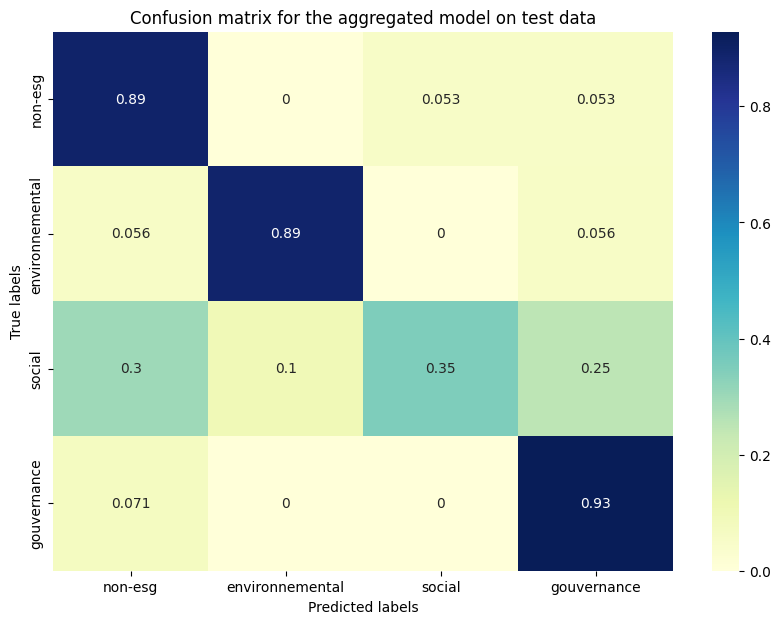

                 precision    recall  f1-score   support

environnemental       0.89      0.89      0.89        18
    gouvernance       0.65      0.93      0.76        14
        non-esg       0.68      0.89      0.77        19
         social       0.88      0.35      0.50        20

       accuracy                           0.75        71
      macro avg       0.77      0.77      0.73        71
   weighted avg       0.78      0.75      0.72        71



In [16]:
# weights = [
#     [0.2, 0.1,0.7,0.1], # cbl
#     [0.7,0.1,0.1,0.8], # cbl-1024
#     [0.1,0.8,0.2,0.1]] # cb
# weights = [
#     [0.2, 0.1,0.2,0.1], # cbl
#     [0.7,0.1,0.3,0.8], # cbl-1024
#     [0.1,0.8,0.5,0.1], # cb
#     # [0.2,0.2,0.2,0.1] # debert-large
# ]

# weights = [[0.32266036, 0.31768953, 0.31216904, 0.27526521], # cb
#            [0.34038895, 0.33574007, 0.34610046, 0.30374093], #cbl
#            [0.33695068, 0.3465704 , 0.3417305 , 0.42099386]] #cbl-1024


# order of weights: non-esg, environnemental, social, gouvernance
# weights = np.round(weights,3)
# print(weights)

df_res['agg_pred'] = None
for i,row in tqdm(df_res.iterrows(), total = len(df_res)):
    cb_pred = row['cb_pred']
    cb_1024_pred = row['cb_1024_pred']
    cbl_pred = row['cbl_pred']
    cbl_1024_pred = row['cbl_1024_pred']
    # debert_base_pred = row['0-shot']
    # debert_large_pred = row['0-shot-EN']
    
    # preds = [cbl_pred, cbl_1024_pred, debert_base_pred, debert_large_pred]
    preds = [cbl_pred, cbl_1024_pred, cb_pred]
    
    pred_dict = {
        "non-esg": 0,
        "environnemental": 0,
        "social": 0,
        "gouvernance": 0
    }
    
    
    pred_dict[cb_pred] += weights[0][list(pred_dict.keys()).index(cb_pred)]
    pred_dict[cb_1024_pred] += weights[1][list(pred_dict.keys()).index(cb_1024_pred)]
    pred_dict[cbl_pred] += weights[2][list(pred_dict.keys()).index(cbl_pred)]
    pred_dict[cbl_1024_pred] += weights[3][list(pred_dict.keys()).index(cbl_1024_pred)]
    # pred_dict[debert_large_pred] += weights[3][list(pred_dict.keys()).index(debert_large_pred)]
    
    best_pred = max(pred_dict, key=pred_dict.get)
    df_res.at[i,'agg_pred'] = best_pred
    
agg_preds = df_res['agg_pred']

utils.print_confusion_matrix(df["esg_category"], agg_preds, title = "Confusion matrix for the aggregated model on test data")
print(classification_report(df['esg_category'], agg_preds, zero_division=0))


In [ ]:
# export only df_res[section_number, text,agg_pred] to csv
df_res[["section_number", "text", "agg_pred"]].to_csv("pv_2312/pv_2312_512_agg_preds.csv", index=False, encoding="utf-8")


# ESGBert model evaluation
Evaluation of ESGBert model with our test dataset, to compare the results with the other models

In [3]:
from easynmt import EasyNMT
import warnings

esgbert_env = pipeline("text-classification", model="ESGBERT/EnvironmentalBERT-environmental")
esgbert_soc = pipeline("text-classification", model="ESGBERT/SocialBERT-social")
esgbert_gov = pipeline("text-classification", model="ESGBERT/GovRoBERTa-governance")
translate_model = EasyNMT('opus-mt',cache_folder="./NMT_model_cache")

WARNING[XFORMERS]: xFormers can't load C++/CUDA extensions. xFormers was built for:
    PyTorch 2.1.1+cu121 with CUDA 1201 (you have 2.1.1+cpu)
    Python  3.11.6 (you have 3.11.2)
  Please reinstall xformers (see https://github.com/facebookresearch/xformers#installing-xformers)
  Memory-efficient attention, SwiGLU, sparse and more won't be available.
  Set XFORMERS_MORE_DETAILS=1 for more details


config.json:   0%|          | 0.00/938 [00:00<?, ?B/s]

d:\azeem\Documents\UNIGE\MSc CS\sentiment-analysis-for-msci-rating\env\Lib\site-packages\huggingface_hub\file_download.py:148: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\azeem\.cache\huggingface\hub\models--ESGBERT--GovRoBERTa-governance. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/351 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

In [7]:
import copy

df2 = copy.deepcopy(df)
# en_text = translate_model.translate(fr_text, source_lang='fr', target_lang='en')

df2["text_en"] = df2["text"].apply(lambda x: translate_model.translate(x, source_lang='fr', target_lang='en'))

d:\azeem\Documents\UNIGE\MSc CS\sentiment-analysis-for-msci-rating\env\Lib\site-packages\transformers\generation\utils.py:1353: UserWarning: Using `max_length`'s default (512) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


In [8]:
df2

,text,esg_category,text_en
0,La vague de chaleur a poussé le Département de...,environnemental,The heat wave prompted the Department of Publi...
1,La météo moins chaude des derniers jours a aid...,environnemental,The warmer weather of the past few days has he...
2,Les précipitations importantes liées à la temp...,environnemental,Major precipitation associated with storm Hila...
3,La météo dans tous ses états racontée par troi...,environnemental,The weather in all its states told by three yo...
4,"Le bilan humain de l'ouragan, qui a dévasté me...",environnemental,"The human impact of the hurricane, which devas..."
...,...,...,...
66,Nona Source est une librairie de tissus collec...,non-esg,Nona Source is a bookshop of fabrics collected...
67,"Ce mardi 26 mars, de nombreuses personnalités ...",non-esg,"On Tuesday, 26 March, many personalities gathe..."
68,Après avoir déclaré en 2017 faire partie des n...,non-esg,After declaring in 2017 to be one of the many ...
69,"Lisbonne et Rome, capitales du Portugal et de ...",non-esg,"Lisbon and Rome, capitals of Portugal and Ital..."


In [9]:
df_env = df2[df2.esg_category == "environnemental"]
df_soc = df2[df2.esg_category == "social"]
df_gov = df2[df2.esg_category == "gouvernance"]

for i,row in tqdm(df_env.iterrows(), total = len(df_env)):
    text = row['text_en']
    df2.at[i,"esgbert_env"] = esgbert_env(text)[0]['label']
    
for i,row in tqdm(df_soc.iterrows(), total = len(df_soc)):
    text = row['text_en']
    df2.at[i,"esgbert_soc"] = esgbert_soc(text)[0]['label']

for i,row in tqdm(df_gov.iterrows(), total = len(df_gov)):
    text = row['text_en']
    df2.at[i,"esgbert_gov"] = esgbert_gov(text)[0]['label']


    


100%|██████████| 14/14 [00:01<00:00, 12.97it/s]


In [10]:
df2[df.esg_category == "social"]

,text,esg_category,text_en,esgbert_env,esgbert_soc,esgbert_gov
18,L’accord entre les représentants des travaille...,social,The agreement between workers' representatives...,NaN,social,NaN
19,Les discours pointant le succès de nos formati...,social,The speeches pointing to the success of our vo...,NaN,none,NaN
20,Les Gazaouis pris au piège de la «deuxième pha...,social,"Gazans trapped in the ""second phase of the war...",NaN,none,NaN
21,Une entreprise reconnue pour prendre soin de s...,social,A company recognized to take care of its workf...,NaN,none,NaN
22,Le renforcement de la santé et de la sécurité ...,social,Strengthening occupational health and safety i...,NaN,social,NaN
23,"Les dirigeants du syndicat des scénaristes, on...",social,"The directors of the screenwriters' union, app...",NaN,none,NaN
24,"Depuis lundi, trois jours de grève touchent le...",social,"Since Monday, three days of strike have been i...",NaN,none,NaN
25,"Plus de 50% des travailleurs, un taux record, ...",social,"More than 50% of workers, a record rate, do no...",NaN,social,NaN
26,Des centaines d'usines de confection au Bangla...,social,Hundreds of garment factories in Bangladesh ha...,NaN,none,NaN
27,La lutte contre la traite d'êtres humains est ...,social,The fight against trafficking in human beings ...,NaN,social,NaN


In [11]:
# get columns text_En and esgbert_env and only rows with esg_category == "environmental"
df_res_env = df2[df2.esg_category == "environnemental"][["text_en","esg_category", "esgbert_env"]]
df_res_soc = df2[df2.esg_category == "social"][["text_en","esg_category", "esgbert_soc"]]
df_res_gov = df2[df2.esg_category == "gouvernance"][["text_en","esg_category", "esgbert_gov"]]


# replace environmental by environnemental
df_res_env["esgbert_env"] = df_res_env["esgbert_env"].apply(lambda x: x.replace("environmental", "environnemental"))
df_res_gov["esgbert_gov"] = df_res_gov["esgbert_gov"].apply(lambda x: x.replace("governance", "gouvernance"))

# calculate accuracy b\w esg_category and esgbert_env and not classification score
print(f"Accuracy environmental texts: {classification_report(df_res_env['esg_category'], df_res_env['esgbert_env'], zero_division=0, output_dict=True)['accuracy']}")
print(f"Accuracy social texts: {classification_report(df_res_soc['esg_category'], df_res_soc['esgbert_soc'], zero_division=0, output_dict=True)['accuracy']}")
print(f"Accuracy governance texts: {classification_report(df_res_gov['esg_category'], df_res_gov['esgbert_gov'], zero_division=0, output_dict=True)['accuracy']}")

Accuracy environmental texts: 0.7222222222222222
Accuracy social texts: 0.4
Accuracy governance texts: 0.07142857142857142
